<a href="https://colab.research.google.com/github/suvedeisoyol/Datathon-mta/blob/main/MTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Load bus stop data
url = "https://raw.githubusercontent.com/suvedeisoyol/Datathon-mta/main/MTA_Bus_Route_Segment_Speeds__2023_-_2024_20250922.csv"
bus_df = pd.read_csv(url)

# Rename columns for clarity
bus_df.rename(columns={
    "Route ID": "route_id",
    "Timepoint Stop Name": "stop_name",
    "Timepoint Stop Latitude": "lat",
    "Timepoint Stop Longitude": "lon"
}, inplace=True)

# Drop rows with missing coordinates
bus_df = bus_df.dropna(subset=["lat", "lon"])

# Load ACE routed bus list
url_ACE_route = "https://data.ny.gov/resource/ki2b-sg5y.csv"
ACE_route = pd.read_csv(url_ACE_route)

# Define full list of CUNY campuses
cuny_coords = {
    "Baruch College": (40.7401, -73.9836),
    "Hunter College": (40.7687, -73.9649),
    "City College": (40.8200, -73.9496),
    "Brooklyn College": (40.6300, -73.9558),
    "Queens College": (40.7365, -73.8215),
    "John Jay College": (40.7690, -73.9887),
    "Lehman College": (40.8781, -73.8895),
    "College of Staten Island": (40.6040, -74.1502),
    "Medgar Evers College": (40.6695, -73.9440),
    "York College": (40.7021, -73.7969),
    "Bronx Community College": (40.8564, -73.9101),
    "LaGuardia Community College": (40.7440, -73.9355),
    "Hostos Community College": (40.8170, -73.9171),
    "Kingsborough Community College": (40.5830, -73.9346),
    "Queensborough Community College": (40.7554, -73.7562),
    "Guttman Community College": (40.7528, -73.9846)
}

# Function to find closest N stops with route info
def closest_stops(campus_name, campus_coord, stops_df, top_n=6):
    stops_df["distance_km"] = stops_df.apply(
        lambda row: geodesic(campus_coord, (row["lat"], row["lon"])).km,
        axis=1
    )
    closest = stops_df.sort_values("distance_km").head(top_n)
    closest["Campus"] = campus_name
    return closest[["Campus", "stop_name", "lat", "lon", "distance_km", "route_id"]]

# Compile results for all campuses
results = pd.concat([
    closest_stops(name, coord, bus_df)
    for name, coord in cuny_coords.items()
], ignore_index=True)

# Display sorted results
#results.sort_values(["Campus", "distance_km"]).reset_index(drop=True)


# Creating new column that show the route is ACE implemented or not
# First, inspect the column names in ACE_route
print(ACE_route.columns)

# Let's assume ACE_route has a column like 'route' or 'route_id' — adjust as needed
# Standardize the join key in both DataFrames
results['route_id'] = results['route_id'].astype(str).str.strip().str.upper()
ACE_route['route_id'] = ACE_route['route'].astype(str).str.strip().str.upper()

# Convert to datetime, then keep only the date part
ACE_route['implementation_date'] = pd.to_datetime(
    ACE_route['implementation_date'], errors='coerce'
).dt.date


# Merge on route_id
merged_df = results.merge(
    ACE_route,
    on='route_id',
    how='left'  # 'left' keeps all rows from results, even if no match in ACE_route
)

# Check the merged result
merged_df.head()



Index(['route', 'program', 'implementation_date'], dtype='object')


,Campus,stop_name,lat,lon,distance_km,route_id,route,program,implementation_date
0,Baruch College,3 AV/E 23 ST,40.739218,-73.982771,0.120401,M102,NaN,NaN,NaN
1,Baruch College,3 AV/E 23 ST,40.739218,-73.982771,0.120401,M101,M101,ACE,2024-09-16
2,Baruch College,3 AV/E 23 ST,40.739218,-73.982771,0.120401,M103,NaN,NaN,NaN
3,Baruch College,3 AV/E 23 ST,40.738982,-73.983129,0.130371,M102,NaN,NaN,NaN
4,Baruch College,3 AV/E 23 ST,40.738982,-73.983129,0.130371,M103,NaN,NaN,NaN


In [5]:
# Trying to find most used routes that have the college nearby stop
popular_route = "https://data.ny.gov/resource/wrt8-4b59.csv?$query=SELECT%0A%20%20%60route_id%60%2C%0A%20%20avg(%60number_of_customers%60)%20AS%20%60avg_number_of_customers%60%0AWHERE%0A%20%20%60month%60%0A%20%20%20%20BETWEEN%20%222024-09-01T15%3A41%3A09%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20AND%20%222024-12-31T15%3A41%3A09%22%20%3A%3A%20floating_timestamp%0AGROUP%20BY%20%60route_id%60"
pop_df = pd.read_csv(popular_route)

# Merge and keep only the column you want
merged_df = merged_df.merge(
    pop_df[['route_id', 'avg_number_of_customers']],  # only bring this column
    on='route_id',
    how='left'
)



In [8]:
merged_df
merged_df.sort_values(by="avg_number_of_customers", ascending = False).dropna().head()

,Campus,stop_name,lat,lon,distance_km,route_id,route,program,implementation_date,avg_number_of_customers
83,Hostos Community College,E 149 ST/MELROSE AV,40.816280,-73.918103,0.116420,BX19,BX19,ACE,2024-06-20,392212.693333
82,Hostos Community College,E 149 ST/MELROSE AV,40.816280,-73.918103,0.116420,BX19,BX19,ABLE,2022-11-28,392212.693333
26,Queens College,MAIN ST/MELBOURNE AV,40.733963,-73.825189,0.420089,Q44+,Q44+,ACE,2024-06-20,236391.483822
25,Queens College,MAIN ST/MELBOURNE AV,40.733963,-73.825189,0.420089,Q44+,Q44+,ABLE,2022-10-03,236391.483822
30,Queens College,MAIN ST/63 AV,40.739335,-73.824970,0.430143,Q44+,Q44+,ACE,2024-06-20,236391.483822


Comment: Since BX19 is the most commonly used bus route that is close to CUNY college Hostos Community College. It is worth exploring effect of ACE

#BUS Route BX19

In [10]:
def ACE_violation_number(bus_route):
    """
    Returns df of the number of ACE violations for the given bus route.
    """

    if '+' in bus_route:
        bus_route = bus_route.replace('+', '%2B')

    url = f"https://data.ny.gov/resource/kh8p-hcbm.csv?$query=SELECT%0A%20%20date_trunc_ym(%60first_occurrence%60)%20AS%20%60by_month_first_occurrence%60%2C%0A%20%20count(*)%20AS%20%60count%60%0AWHERE%0A%20%20caseless_one_of(%60bus_route_id%60%2C%20%22{bus_route}%22)%0A%20%20AND%20%60first_occurrence%60%0A%20%20%20%20%20%20%20%20BETWEEN%20%222024-01-01T15%3A26%3A33%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20%20%20%20%20AND%20%222025-12-31T15%3A26%3A33%22%20%3A%3A%20floating_timestamp%0AGROUP%20BY%20date_trunc_ym(%60first_occurrence%60)"
    df = pd.read_csv(url)
    df.rename(columns={'by_month_first_occurrence': 'month'}, inplace=True)
    df.rename(columns={'month': 'date'}, inplace=True)
    df['date'] = pd.to_datetime(
    df['date'], errors='coerce').dt.date
    return df

In [15]:
df_bx19 = ACE_violation_number("BX19").sort_values(by="date")

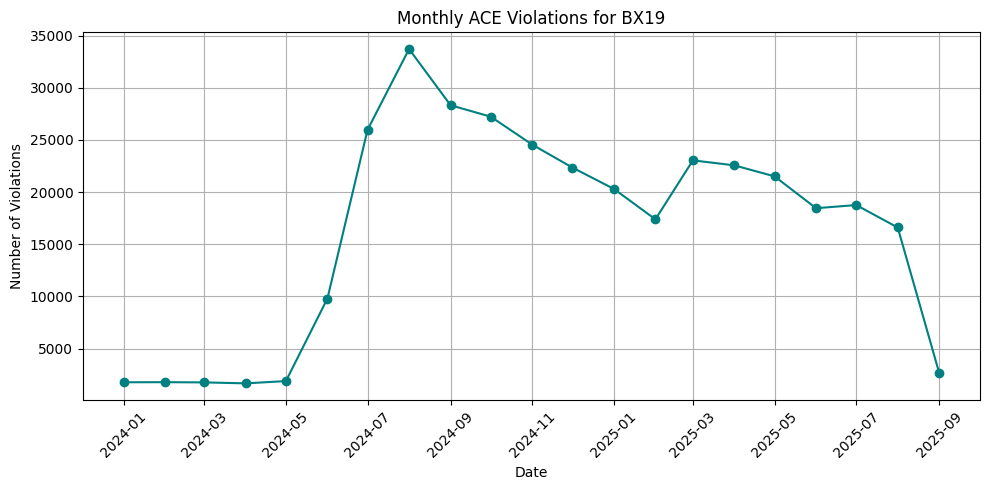

In [16]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_bx19['date'], df_bx19['count'], marker='o', linestyle='-', color='teal')
plt.title('Monthly ACE Violations for BX19')
plt.xlabel('Date')
plt.ylabel('Number of Violations')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
url_speed = "https://data.ny.gov/resource/kufs-yh3x.csv?$query=SELECT%0A%20%20%60direction%60%2C%0A%20%20%60timepoint_stop_id%60%2C%0A%20%20%60timepoint_stop_name%60%2C%0A%20%20%60next_timepoint_stop_id%60%2C%0A%20%20%60next_timepoint_stop_name%60%2C%0A%20%20stddev_samp(%60average_road_speed%60)%20AS%20%60stddev_samp_average_road_speed%60%0AWHERE%20caseless_one_of(%60route_id%60%2C%20%22BX19%22)%0AGROUP%20BY%0A%20%20%60direction%60%2C%0A%20%20%60timepoint_stop_id%60%2C%0A%20%20%60timepoint_stop_name%60%2C%0A%20%20%60next_timepoint_stop_name%60%2C%0A%20%20%60next_timepoint_stop_id%60%2C%0A%20%20%60next_timepoint_stop_name%60%0AORDER%20BY%0A%20%20%60direction%60%20DESC%20NULL%20LAST%2C%0A%20%20%60stddev_samp_average_road_speed%60%20DESC%20NULL%20LAST"
df_speed = pd.read_csv(url_speed)
df_speed.head()

,direction,timepoint_stop_id,timepoint_stop_name,next_timepoint_stop_id,next_timepoint_stop_name,stddev_samp_average_road_speed
0,S,104221,SOUTHERN BLVD/E 163 ST,104233,E 149 ST/MELROSE AV,2.003434
1,S,103640,SOUTHERN BLVD/BOTANICAL GARDENS,103917,SOUTHERN BLVD/EAST TREMONT AV,1.687035
2,S,103917,SOUTHERN BLVD/EAST TREMONT AV,104221,SOUTHERN BLVD/E 163 ST,1.676587
3,S,104233,E 149 ST/MELROSE AV,403696,W 145 ST/BROADWAY,1.376121
4,S,403696,W 145 ST/BROADWAY,803194,RIVERBANK STATE PARK RDWY/RIVERBANK STATE PARK,0.825113


In [15]:
url_violation = "https://data.ny.gov/resource/kh8p-hcbm.csv?$query=SELECT%0A%20%20%60stop_id%60%2C%0A%20%20%60stop_name%60%2C%0A%20%20count(%60violation_id%60)%20AS%20%60count_violation_id%60%2C%0A%20%20%60bus_stop_georeference%60%0AWHERE%0A%20%20caseless_one_of(%60bus_route_id%60%2C%20%22BX19%22)%0A%20%20AND%20%60first_occurrence%60%0A%20%20%20%20%20%20%20%20BETWEEN%20%222024-10-06T13%3A03%3A13%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20%20%20%20%20AND%20%222025-10-06T13%3A03%3A13%22%20%3A%3A%20floating_timestamp%0AGROUP%20BY%20%60stop_id%60%2C%20%60stop_name%60%2C%20%60bus_stop_georeference%60%0AORDER%20BY%20%60count_violation_id%60%20DESC%20NULL%20LAST"
df_violation = pd.read_csv(url_violation)
df_violation.head()

,stop_id,stop_name,count_violation_id,bus_stop_georeference
0,104242,SOUTHERN BLVD/AVENUE SAINT JOHN,10211,POINT (-73.901337 40.812995)
1,403690,W 145 ST/ADAM C POWELL BLVD,9999,POINT (-73.938795 40.821618)
2,101318,SOUTHERN BLVD/E 149 ST,7548,POINT (-73.903625 40.812179)
3,103507,SOUTHERN BLVD/HUNTS POINT AV,7432,POINT (-73.891607 40.82082)
4,403695,W 145 ST/AMSTERDAM AV,7171,POINT (-73.947373 40.825231)


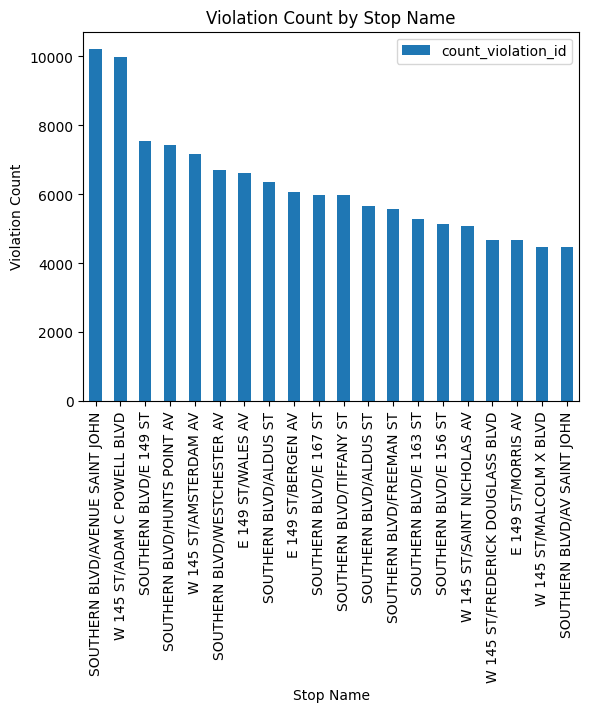

In [67]:
df_violation_top = df_violation.head(20)
df_violation_top.plot( x = "stop_name", y = "count_violation_id", kind = "bar")
plt.title("Violation Count by Stop Name")
plt.xlabel("Stop Name")
plt.ylabel("Violation Count")
plt.xticks(rotation = 90)
plt.show()

In [68]:
import folium
from folium.plugins import HeatMap
from IPython.display import IFrame

df_violation_top[['lon', 'lat']] = df_violation_top['bus_stop_georeference'].str.extract(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)').astype(float)

# Create base map centered on the Bronx
m = folium.Map(
    location=[40.82, -73.91],
    zoom_start=13,
    control_scale=False,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False
)

# Prepare heatmap data: [lat, lon, weight]
heat_data = [
    [row['lat'], row['lon'], row['count_violation_id']]
    for _, row in df_violation_top.iterrows()
]

# Add heatmap layer
from folium.plugins import HeatMap

HeatMap(heat_data, radius=15, blur=20, max_zoom=1).add_to(m)

for _, row in df_violation.head(20).iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{row['stop_name']} ({row['count_violation_id']} violations)",
        icon=folium.Icon(color='blue', icon_size=(2, 2), shadow_size=(0, 0))
    ).add_to(m)

# Save or display
m.save("violation_heatmap.html")
# Display in notebook
m


/tmp/ipython-input-630013691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_violation_top[['lon', 'lat']] = df_violation_top['bus_stop_georeference'].str.extract(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)').astype(float)


Observation: However at single stop "SOUTHERN BLVD/AVENUE SAINT JOHN" has the most vialotion but we see more heat overlap around bus stop "SOUTHERN BLVD/E 163 ST". Surprisingly which proves that that is the location we observed the most standart deviation of speed.

# Exploring around bus stop SOUTHERN BLVD/E 163 ST

In [61]:
# Bus
df_speed_top = df_speed.sort_values('stddev_samp_average_road_speed', ascending=False).head(5)
df_speed_top

,direction,timepoint_stop_id,timepoint_stop_name,next_timepoint_stop_id,next_timepoint_stop_name,stddev_samp_average_road_speed
5,N,103507,SOUTHERN BLVD/HUNTS POINT AV,101335,SOUTHERN BLVD/EAST TREMONT AV,2.043223
0,S,104221,SOUTHERN BLVD/E 163 ST,104233,E 149 ST/MELROSE AV,2.003434
1,S,103640,SOUTHERN BLVD/BOTANICAL GARDENS,103917,SOUTHERN BLVD/EAST TREMONT AV,1.687035
2,S,103917,SOUTHERN BLVD/EAST TREMONT AV,104221,SOUTHERN BLVD/E 163 ST,1.676587
6,N,103748,E 149 ST/BERGEN AV,103507,SOUTHERN BLVD/HUNTS POINT AV,1.513191


In [71]:
bus_stop = df_violation[df_violation["stop_id"] == 104221]
lon = bus_stop["lon"].values[0]
lat = bus_stop["lat"].values[0]

In [85]:
#!pip install geopy
from geopy.distance import geodesic
import pandas as pd

# Coordinates for SOUTHERN BLVD/E 163 ST (example—replace with actual if needed)
target_location = (lat, lon)  # latitude, longitude

close_bus_stop = df_violation_top.copy()
# Calculate distance to target stop
close_bus_stop['distance_km'] = close_bus_stop.apply(
    lambda row: geodesic(target_location, (row['lat'], row['lon'])).km,
    axis=1
)

# Sort by proximity
nearby_stops = close_bus_stop.sort_values(by='distance_km').head(10)

# Display top 10 closest stops
nearby_stops[['stop_id','stop_name', 'lat', 'lon', 'distance_km', "count_violation_id"]]

,stop_id,stop_name,lat,lon,distance_km,count_violation_id
13,104221,SOUTHERN BLVD/E 163 ST,40.820842,-73.891773,0.000000,5275
3,103507,SOUTHERN BLVD/HUNTS POINT AV,40.820820,-73.891607,0.014216,7432
7,101360,SOUTHERN BLVD/ALDUS ST,40.822869,-73.891817,0.225130,6361
11,101324,SOUTHERN BLVD/ALDUS ST,40.823173,-73.891755,0.258863,5668
10,101322,SOUTHERN BLVD/TIFFANY ST,40.818544,-73.893764,0.305512,5970
5,100273,SOUTHERN BLVD/WESTCHESTER AV,40.824370,-73.891944,0.392052,6710
9,101327,SOUTHERN BLVD/E 167 ST,40.827187,-73.891876,0.704669,5991
14,101320,SOUTHERN BLVD/E 156 ST,40.815124,-73.897299,0.787754,5138
12,101356,SOUTHERN BLVD/FREEMAN ST,40.830102,-73.891908,1.028391,5587
19,104099,SOUTHERN BLVD/AV SAINT JOHN,40.812932,-73.900976,1.172371,4461


# Further Investigation in violation around those locations
* 104221	SOUTHERN BLVD/E 163 ST	40.820842	-73.891773	0.000000	5275
* 103507	SOUTHERN BLVD/HUNTS POINT AV	40.820820	-73.891607	0.014216	7432
* 101360	SOUTHERN BLVD/ALDUS ST	40.822869	-73.891817	0.225130	6361
* 101324	SOUTHERN BLVD/ALDUS ST	40.823173	-73.891755	0.258863	5668
* 101322	SOUTHERN BLVD/TIFFANY ST	40.818544	-73.893764	0.305512	5970
* 100273	SOUTHERN BLVD/WESTCHESTER AV	40.824370	-73.891944	0.392052	6710

In [86]:
violation_type_url = "https://data.ny.gov/resource/kh8p-hcbm.csv?$query=SELECT%20%60violation_status%60%2C%20count(%60violation_id%60)%20AS%20%60count_violation_id%60%0AWHERE%0A%20%20caseless_one_of(%60bus_route_id%60%2C%20%22BX19%22)%0A%20%20AND%20%60first_occurrence%60%0A%20%20%20%20%20%20%20%20BETWEEN%20%222024-10-06T13%3A03%3A13%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20%20%20%20%20AND%20%222025-10-06T13%3A03%3A13%22%20%3A%3A%20floating_timestamp%0A%20%20AND%20caseless_one_of(%0A%20%20%20%20%60stop_id%60%2C%0A%20%20%20%20%22104221%22%2C%0A%20%20%20%20%22103507%22%2C%0A%20%20%20%20%22101360%22%2C%0A%20%20%20%20%22101324%22%2C%0A%20%20%20%20%22101322%22%2C%0A%20%20%20%20%22100273%22%0A%20%20)%0AGROUP%20BY%20%60violation_status%60%0AORDER%20BY%20%60count_violation_id%60%20DESC%20NULL%20LAST"
df_violation_type = pd.read_csv(violation_type_url)
df_violation_type

,violation_status,count_violation_id
0,VIOLATION ISSUED,24454
1,EXEMPT - COMMERCIAL UNDER 20,5713
2,DRIVER/VEHICLE INFO MISSING,3150
3,TECHNICAL ISSUE/OTHER,2470
4,EXEMPT - EMERGENCY VEHICLE,857
5,EXEMPT - OTHER,486
6,EXEMPT - BUS/PARATRANSIT,286


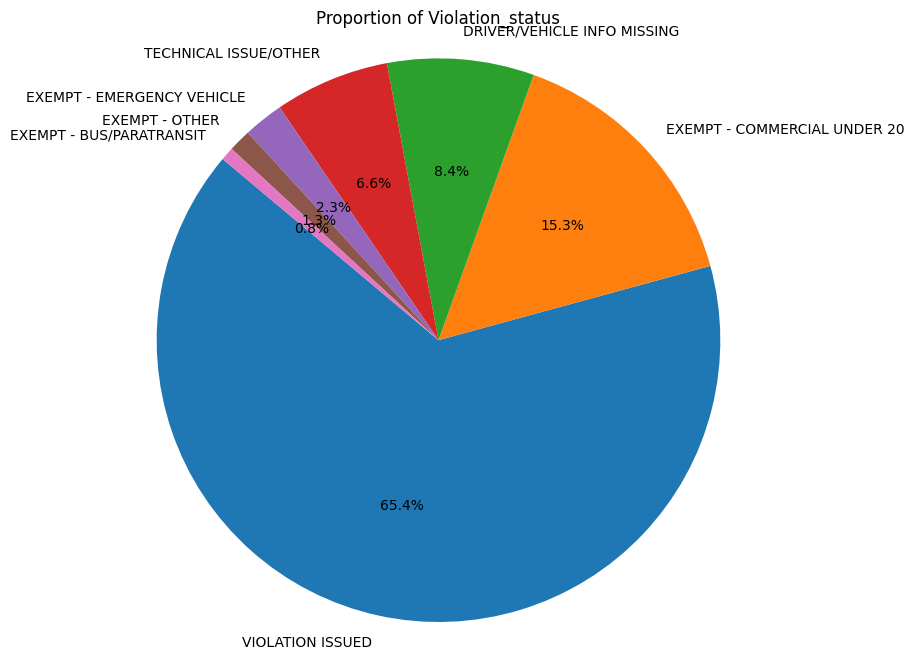

In [88]:
# Prepare data
labels = df_violation_type['violation_status']
sizes = df_violation_type['count_violation_id']

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax.set_title('Proportion of Violation_status')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.show()

Comment: Around these bus Stop, we observed that 65 percent of violation are issued. Question is Why and How come?

In [92]:
type_issued_url = "https://data.ny.gov/resource/kh8p-hcbm.csv?$query=SELECT%20%60violation_type%60%2C%20count(%60violation_id%60)%20AS%20%60count_violation_id%60%0AWHERE%0A%20%20caseless_one_of(%60bus_route_id%60%2C%20%22BX19%22)%0A%20%20AND%20%60first_occurrence%60%0A%20%20%20%20%20%20%20%20BETWEEN%20%222024-10-06T13%3A03%3A13%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20%20%20%20%20AND%20%222025-10-06T13%3A03%3A13%22%20%3A%3A%20floating_timestamp%0A%20%20AND%20caseless_one_of(%0A%20%20%20%20%60stop_id%60%2C%0A%20%20%20%20%22104221%22%2C%0A%20%20%20%20%22103507%22%2C%0A%20%20%20%20%22101360%22%2C%0A%20%20%20%20%22101324%22%2C%0A%20%20%20%20%22101322%22%2C%0A%20%20%20%20%22100273%22%0A%20%20)%0A%20%20AND%20caseless_one_of(%60violation_status%60%2C%20%22VIOLATION%20ISSUED%22)%0AGROUP%20BY%20%60violation_type%60"
df_violation_type_issued = pd.read_csv(type_issued_url)
df_violation_type_issued

,violation_type,count_violation_id
0,MOBILE BUS STOP,5383
1,MOBILE DOUBLE PARKED,19071


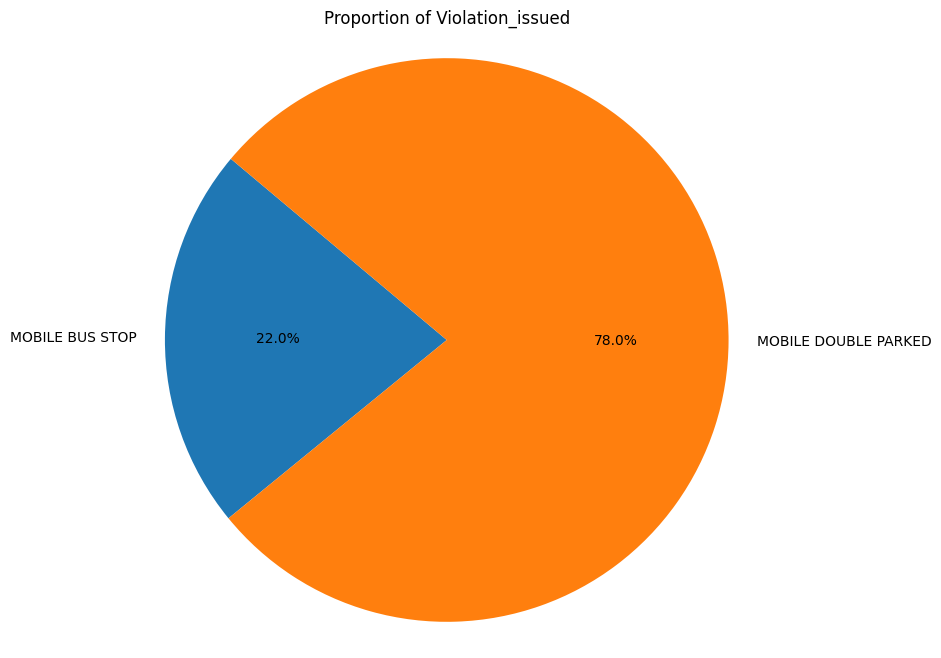

In [91]:
labels = df_violation_type_issued['violation_type']
sizes = df_violation_type_issued['count_violation_id']

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax.set_title('Proportion of Violation_issued')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.show()

In [4]:
Viol_per_vehicle_url = "https://data.ny.gov/resource/kh8p-hcbm.csv?$query=SELECT%0A%20%20%60violation_type%60%2C%0A%20%20count(%60violation_id%60)%20AS%20%60count_violation_id%60%2C%0A%20%20%60vehicle_id%60%0AWHERE%0A%20%20caseless_one_of(%60bus_route_id%60%2C%20%22BX19%22)%0A%20%20AND%20%60first_occurrence%60%0A%20%20%20%20%20%20%20%20BETWEEN%20%222024-10-06T13%3A03%3A13%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20%20%20%20%20AND%20%222025-10-06T13%3A03%3A13%22%20%3A%3A%20floating_timestamp%0A%20%20AND%20caseless_one_of(%0A%20%20%20%20%60stop_id%60%2C%0A%20%20%20%20%22104221%22%2C%0A%20%20%20%20%22103507%22%2C%0A%20%20%20%20%22101360%22%2C%0A%20%20%20%20%22101324%22%2C%0A%20%20%20%20%22101322%22%2C%0A%20%20%20%20%22100273%22%0A%20%20)%0A%20%20AND%20caseless_one_of(%60violation_status%60%2C%20%22VIOLATION%20ISSUED%22)%0AGROUP%20BY%20%60violation_type%60%2C%20%60vehicle_id%60%0AORDER%20BY%20%60count_violation_id%60%20DESC%20NULL%20LAST"
df_violation_per_vehicle = pd.read_csv(Viol_per_vehicle_url)
df_violation_per_vehicle.head(10)

,violation_type,count_violation_id,vehicle_id
0,MOBILE DOUBLE PARKED,72,992b86a0166250ce8a3ef831a847ea8a0906d9a00b7a94...
1,MOBILE DOUBLE PARKED,48,b17dea861dd76b4b64875f919793de492a7dd27bd2586f...
2,MOBILE BUS STOP,43,10cd4ce61793f7db43175502ec50431410ed799cce4e03...
3,MOBILE DOUBLE PARKED,26,3ce2496d5bf2b460f75fee8b9e7fe400615f546286210d...
4,MOBILE BUS STOP,26,93b2988a1e07f1c5faf041299a0a08cd585494e613cdb1...
5,MOBILE DOUBLE PARKED,23,9dfcfbabdd9c33be0bcc305e09391fc96fde6f0721fda0...
6,MOBILE DOUBLE PARKED,20,976fb1cb351d98e4c15ba03dd2d1ef66a0e49c7c4b1a9c...
7,MOBILE DOUBLE PARKED,18,10cd4ce61793f7db43175502ec50431410ed799cce4e03...
8,MOBILE BUS STOP,18,2adc6120ded243d0275fda582101aa6ed8f14834fabf48...
9,MOBILE DOUBLE PARKED,17,a97795be075ffb4013e3f1369ff83765bc26ffb1f12971...


# Conclusion:
There are repeatitive users who violated the regulation 72 times within 1 year period. Those areas could be the issue for traffic congestion and cause of slowed bus operation.

# Further Investigation and Questions:
How much delay does it cause to the Bus route BX19 and What are the reasons of those violaters keep violating around same zone. Are there paying the fines? Is charging for ticket ideal way to solve the delay?